In [5]:
from io import BytesIO
from pathlib import Path

import contextily as ctx
import datashader as ds
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rio
from owslib.wfs import WebFeatureService

project_root = Path.cwd().parent

In [6]:
def load_raster_data(url, filename=None):
    if filename:
        p = f"zip+{url}!{filename}"
    else:
        p = url
    return rio.open_rasterio(p, masked=True)


def load_wfs_layer(layer_name):
    wfs_url = "https://idecor-ws.mapascordoba.gob.ar/geoserver/idecor/wfs"
    srs = "EPSG:22174"

    # Initialize WFS connection
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")

    # Get the data
    response = wfs.getfeature(typename=layer_name, srsname=srs)

    # Read the response into a GeoDataFrame
    return gpd.read_file(BytesIO(response.read()))

In [7]:
# Load NONO data
nono_data = load_wfs_layer("idecor:radios_urbanos")
nono_data = nono_data[nono_data["nombre"] == "NONO"]

# Load water courses data
water_courses = load_wfs_layer("idecor:cursos_agua")

# Make sure both layers are in the same projection
water_courses = water_courses.to_crs(nono_data.crs)

# Clip the water courses to the NONO area
water_courses_nono = gpd.clip(water_courses, nono_data)

In [8]:
# Create a function to scale the line widths
def scale_line_width(orden):
    return 2 - (orden - 1) * (1.9 / 4)


# Plot NONO boundary with no fill - transform to Web Mercator
nono_data_3857 = nono_data.to_crs(epsg=3857)

# Plot water courses with scaled line widths - transform to Web Mercator
water_courses_3857 = water_courses_nono.to_crs(epsg=3857)

In [6]:
# Load flood depth data
flood_depth_url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP100/ID74_S30_W70_RP100_depth.tif"
flood_depth = load_raster_data(flood_depth_url)

# Get the original CRS from the source
source_crs = flood_depth.rio.crs
print(f"Source CRS: {source_crs}")

# Reproject to Web Mercator and clip to NONO extent
flood_depth_3857 = flood_depth.rio.reproject(
    dst_crs="EPSG:3857",
    resolution=100,  # 100m resolution
).rio.clip(nono_data_3857.geometry, from_disk=True)

print(
    f"Data range after reprojection: {float(flood_depth_3857.min())} to {float(flood_depth_3857.max())}"
)
print(f"Data shape: {flood_depth_3857.shape}")

Source CRS: EPSG:4326
Data range after reprojection: 0.12700000405311584 to 21.905000686645508
Data shape: (1, 151, 236)


In [7]:
# Load GHSL data
ghsl_url = (
    "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/"
    "GHS_POP_GLOBE_R2023A/"
    "GHS_POP_E2025_GLOBE_R2023A_54009_100/"
    "V1-0/"
    "tiles/"
    "GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.zip"
)
ghsl = load_raster_data(
    ghsl_url, "GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.tif"
)

# First reproject to Web Mercator
ghsl_3857 = ghsl.rio.reproject(
    dst_crs="EPSG:3857",
    resolution=100,  # 100m resolution
)

# Then clip to NONO extent
ghsl_clipped = ghsl_3857.rio.clip(nono_data.to_crs("EPSG:3857").geometry)

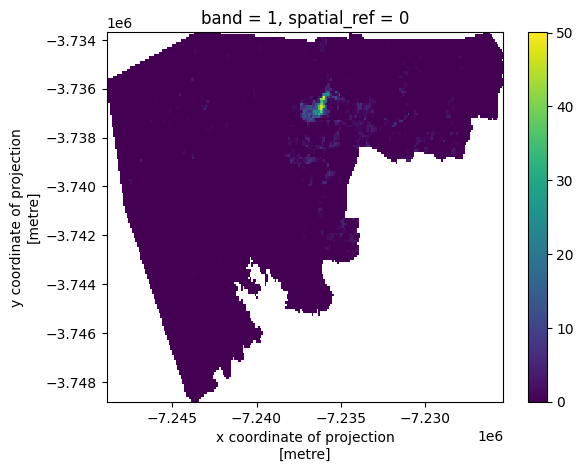

In [8]:
ghsl_clipped.plot()

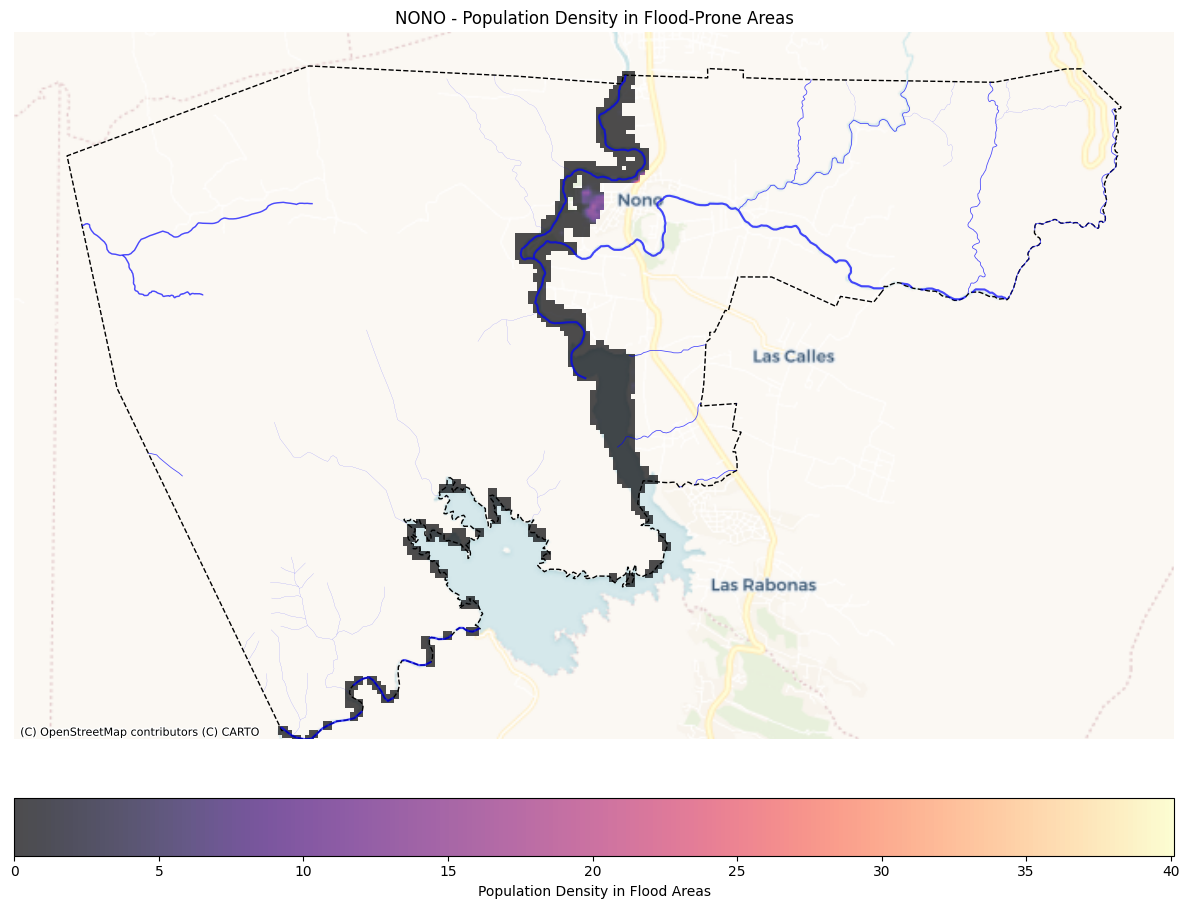

In [9]:
# Create the map
fig, ax = plt.subplots(figsize=(12, 12))

# Create datashader canvas
canvas = ds.Canvas(plot_width=1200, plot_height=1200)

# Create mask for flood areas (where flood depth > 0)
flood_mask = flood_depth_3857 > 0

# First rasterize the flood mask
flood_agg = canvas.raster(flood_mask.sel(band=1))

# Then rasterize GHSL data
ghsl_agg = canvas.raster(ghsl_3857.sel(band=1))

# Apply the mask to the rasterized data
masked_ghsl = ghsl_agg.where(flood_agg)

# Plot the masked population data
masked_ghsl.plot.imshow(
    ax=ax,
    alpha=0.7,
    cmap="magma",
    add_colorbar=True,
    cbar_kwargs={
        "label": "Population Density in Flood Areas",
        "orientation": "horizontal",
        "pad": 0.05,
        "location": "bottom",
    },
)

# Plot vector data
nono_data_3857.plot(
    ax=ax, facecolor="none", edgecolor="black", linestyle="--", linewidth=1
)

# Plot water courses
for orden in sorted(water_courses_3857["orden"].unique()):
    subset = water_courses_3857[water_courses_3857["orden"] == orden]
    line_width = scale_line_width(orden)
    subset.plot(ax=ax, color="blue", linewidth=line_width, alpha=0.7)

# Add basemap
ctx.add_basemap(
    ax, crs=flood_depth_3857.rio.crs, source=ctx.providers.CartoDB.Voyager, zorder=-1
)

# Remove axis labels and ticks
ax.set_axis_off()

# Adjust layout to prevent legend overlap
plt.tight_layout()

plt.title("NONO - Population Density in Flood-Prone Areas")
plt.show()

In [10]:
import s2sphere
import geopandas as gpd
import boto3
from botocore.config import Config

# Convert from Web Mercator to WGS84 (lat/lon)
nono_wgs84 = nono_data_3857.to_crs(epsg=4326)

# Calculate centroid in Web Mercator first
center_3857 = nono_data_3857.geometry.centroid.iloc[0]

# Then convert the centroid point to WGS84
center_wgs84 = gpd.GeoDataFrame(geometry=[center_3857], crs="EPSG:3857").to_crs(
    epsg=4326
)
center = center_wgs84.geometry.iloc[0]

# Get the S2 cell ID at level 10 (you can adjust the level as needed)
cell = s2sphere.CellId.from_lat_lng(
    s2sphere.LatLng.from_degrees(center.y, center.x)
).parent(10)
cell_id = cell.id()

# Get Nono's cell id
nono_cell = s2sphere.CellId(cell_id)

# Configure S3 client for Source Cooperative with empty credentials
s3 = boto3.client(
    "s3",
    endpoint_url="https://data.source.coop",
    aws_access_key_id="",
    aws_secret_access_key="",
    config=Config(s3={"addressing_style": "path"}),
)

# List objects in the Argentina directory
response = s3.list_objects_v2(
    Bucket="vida",
    Prefix="google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/",
)

# Extract partition IDs from the keys
partitions = [
    obj["Key"].split("/")[-1].replace(".parquet", "")
    for obj in response.get("Contents", [])
]

# Check each level up to find a matching partition
for level in range(10, 0, -1):  # Start from level 10 and go up
    parent_cell = nono_cell.parent(level)
    parent_id = parent_cell.id()
    print(f"Level {level}: {parent_id}")

    # Check if this parent matches any of the Argentina partitions
    if str(parent_id) in partitions:
        print(f"Found match at level {level}!")
        break

Level 10: 10677235371542052864
Level 9: 10677238670076936192
Level 8: 10677243068123447296
Level 7: 10677260660309491712
Level 6: 10677190291565314048
Level 5: 10676908816588603392
Level 4: 10678034716495446016
Level 3: 10682538316122816512
Found match at level 3!


In [10]:
import duckdb

# Initialize DuckDB connection
con = duckdb.connect()

# Install and load required extensions
con.execute("INSTALL spatial")
con.execute("LOAD spatial")

# Configure S3 settings
con.execute("SET s3_region='us-east-1'")  # or whatever region is appropriate
con.execute("SET s3_endpoint='data.source.coop'")  # Note: removed https://
con.execute("SET s3_use_ssl=true")
con.execute("SET s3_url_style='path'")

In [45]:
# Convert Nono to WGS84
nono_wgs84 = nono_data_3857.to_crs(epsg=4326)
nono_wkt = nono_wgs84.geometry.iloc[0].wkt

# Now query with spatial filtering
query = f"""
SELECT 
    ST_AsText(geometry) as geometry_wkt,
    *
FROM read_parquet('s3://vida/google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/10682538316122816512.parquet')
WHERE ST_Intersects(geometry, ST_GeomFromText('{nono_wkt}'))
"""

df = con.execute(query).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [46]:
import geopandas as gpd

# Create GeoDataFrame using the WKT geometry column
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.GeoSeries.from_wkt(df["geometry_wkt"]), crs="EPSG:3857"
)

In [3]:
import boto3
from botocore.config import Config

# Configure S3 client for Source Cooperative with empty credentials
s3 = boto3.client(
    "s3",
    endpoint_url="https://data.source.coop",
    aws_access_key_id="",
    aws_secret_access_key="",
    config=Config(s3={"addressing_style": "path"}),
)

# List objects in the Argentina directory
response = s3.list_objects_v2(
    Bucket="vida",
    Prefix="google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/",
)

# Extract partition IDs from the keys
partitions = [
    obj["Key"].split("/")[-1].replace(".parquet", "")
    for obj in response.get("Contents", [])
]

print("Available partitions for Argentina:")
print(partitions)

Available partitions for Argentina:
['10682538316122816512', '10718567113141780480', '10790624707179708416', '10826653504198672384', '10862682301217636352', '13564842077639933952', '13672928468696825856', '13708957265715789824']


In [4]:
partitions

['10682538316122816512',
 '10718567113141780480',
 '10790624707179708416',
 '10826653504198672384',
 '10862682301217636352',
 '13564842077639933952',
 '13672928468696825856',
 '13708957265715789824']

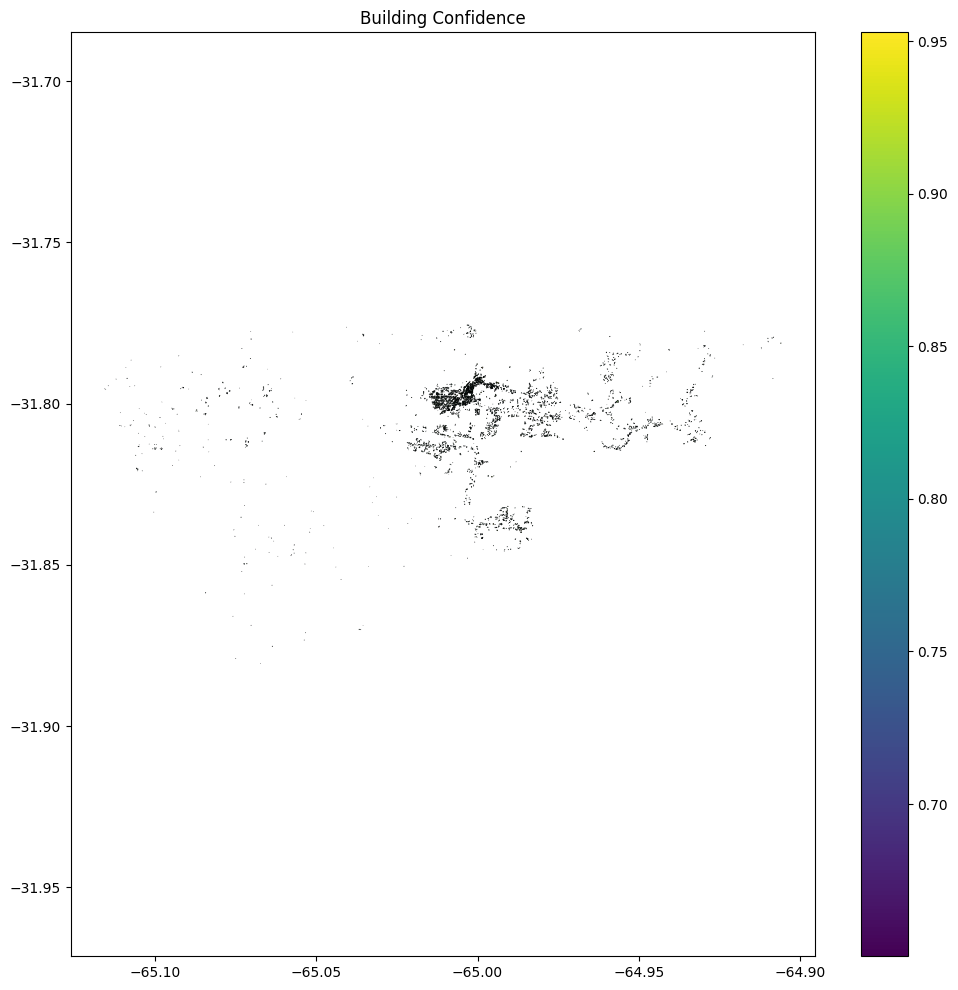

In [49]:
# 3. Plot with proper styling
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(
    column="confidence",
    ax=ax,
    legend=True,
    cmap="viridis",
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
)
plt.title("Building Confidence")
plt.axis("equal")  # This ensures the plot isn't distorted
plt.show()